In [3]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import torchvision
import torchvision.transforms as tranforms
from torch.utils.data import Dataset,DataLoader

In [5]:
train_dataset=torchvision.datasets.FashionMNIST('../data/',download=True,transform=tranforms.Compose([tranforms.ToTensor()]))

test_dataset=torchvision.datasets.FashionMNIST('../data/',download=True,train=False,transform=tranforms.Compose([tranforms.ToTensor()]))

100.0%


Extracting ../data/FashionMNIST\raw\train-images-idx3-ubyte.gz to ../data/FashionMNIST\raw



100.0%


Extracting ../data/FashionMNIST\raw\train-labels-idx1-ubyte.gz to ../data/FashionMNIST\raw



100.0%


Extracting ../data/FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ../data/FashionMNIST\raw



100.0%

Extracting ../data/FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST\raw



In [6]:
train_loader=torch.utils.data.DataLoader(train_dataset,batch_size=100)

test_loader=torch.utils.data.DataLoader(test_dataset,batch_size=100)

In [7]:
labels_map={0:'T-shirt',1: 'Trouser',2: 'Pullover',3:'Dress',4:'Coat',5:'Sandal',6:'Shirt',7:'Sneaker',8:'Bag',9:'Ankle Boot'}

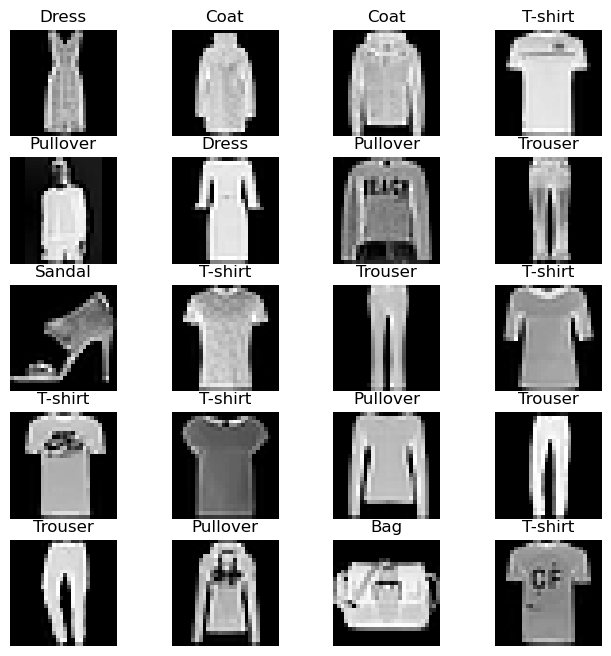

In [9]:
fig=plt.figure(figsize=(8,8))
columns=4;
rows=5;

for i in range(1,columns*rows+1):
    img_xy=np.random.randint(len(train_dataset))
    img=train_dataset[img_xy][0][0,:,:]
    fig.add_subplot(rows,columns,i)
    plt.title(labels_map[train_dataset[img_xy][1]])
    plt.axis('off')
    plt.imshow(img,cmap='gray')
plt.show()

In [10]:
class fashionDnn(nn.Module):
    def __init__(self):
        super(fashionDnn,self).__init__()
        self.fc1=nn.Linear(in_features=784,out_features=256)
        self.drop=nn.Dropout(0.25)
        self.fc2=nn.Linear(in_features=256,out_features=128)
        self.fc3=nn.Linear(in_features=128,out_features=10)

    def forward(self,input_data):
        out=input_data.view(-1,784)
        out=F.relu(self.fc1(out))
        out=self.drop(out)
        out=F.relu(self.fc2(out))
        out=self.fc3(out)
        return out

In [12]:
learnig_rate=0.001
model=fashionDnn()

criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=learnig_rate)
print(model)

fashionDnn(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


In [14]:
num_epochs=5
count=0
loss_list=[]
iteration_list=[]
accuracy_list=[]

prediction_list=[]
label_list=[]

for epoch in range(num_epochs):
    for images,labels in train_loader:
        train=Variable(images.view(100,1,28,28))
        labels=Variable(labels)

        output=model(train)
        loss=criterion(output,labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        count+=1

        if not (count % 50):
            total=0
            correct=0

            for images,labels in test_loader:
                label_list.append(labels)
                test=Variable(images.view(100,1,28,28))
                output=model(test)
                prediction=torch.max(output,1)[1]
                prediction_list.append(prediction)
                correct+=(prediction==labels).sum()
                total+=len(labels)

            accuracy=correct*100/total
            loss_list.append(count)
            accuracy_list.append(accuracy)

        if not (count % 500):
            print('Iteration: {}, Loss: {}, Accuracy: {}%'.format(count,loss.data,accuracy))

Iteration: 500, Loss: 0.5644874572753906, Accuracy: 83.27999877929688%
Iteration: 1000, Loss: 0.4531838297843933, Accuracy: 84.63999938964844%
Iteration: 1500, Loss: 0.32997581362724304, Accuracy: 84.73999786376953%
Iteration: 2000, Loss: 0.4141204059123993, Accuracy: 85.08999633789062%
Iteration: 2500, Loss: 0.2669607102870941, Accuracy: 86.25%
Iteration: 3000, Loss: 0.2938093841075897, Accuracy: 87.13999938964844%


In [15]:
class fashionCnn(nn.Module):
    def __init__(self):
        super(fashionCnn,self).__init__()
        self.layer1=nn.Sequential(
            nn.Conv2d(in_channels=1,out_channels=32,kernel_size=3,padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2)
        )
        self.layer2=nn.Sequential(
            nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc1=nn.Linear(in_features=64*6*6,out_features=600)
        self.drop=nn.Dropout2d(0.25)
        self.fc2=nn.Linear(in_features=600,out_features=120)
        self.fc3=nn.Linear(in_features=120,out_features=10)

    def forward(self,x):
        out=self.layer1(x)
        out=self.layer2(out)
        out=out.view(out.size(0),-1)
        out=self.fc1(out)
        out=self.drop(out)
        out=self.fc2(out)
        out=self.fc3(out)
        return out

In [16]:
learnig_rate=0.001
model=fashionCnn()

criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=learnig_rate)
print(model)

fashionCnn(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


In [17]:
num_epochs=5
count=0
loss_list=[]
iteration_list=[]
accuracy_list=[]

prediction_list=[]
label_list=[]

for epoch in range(num_epochs):
    for images,labels in train_loader:
        train=Variable(images.view(100,1,28,28))
        labels=Variable(labels)

        output=model(train)
        loss=criterion(output,labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        count+=1

        if not (count % 50):
            total=0
            correct=0

            for images,labels in test_loader:
                label_list.append(labels)
                test=Variable(images.view(100,1,28,28))
                output=model(test)
                prediction=torch.max(output,1)[1]
                prediction_list.append(prediction)
                correct+=(prediction==labels).sum()
                total+=len(labels)

            accuracy=correct*100/total
            loss_list.append(count)
            accuracy_list.append(accuracy)

        if not (count % 500):
            print('Iteration: {}, Loss: {}, Accuracy: {}%'.format(count,loss.data,accuracy))

c:\Users\desktop\anaconda3\envs\TORCH_CV_38\lib\site-packages\torch\nn\functional.py:1374: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Iteration: 500, Loss: 0.4242924153804779, Accuracy: 87.93000030517578%
Iteration: 1000, Loss: 0.3608669340610504, Accuracy: 86.5%
Iteration: 1500, Loss: 0.32344532012939453, Accuracy: 86.80000305175781%
Iteration: 2000, Loss: 0.21879830956459045, Accuracy: 89.16000366210938%
Iteration: 2500, Loss: 0.15385602414608002, Accuracy: 90.06999969482422%
Iteration: 3000, Loss: 0.14639507234096527, Accuracy: 90.12000274658203%
